# 1. Install necessary dependencies

In [ ]:
%pip install scikit-learn opencv-python numpy matplotlib torchvision facenet-pytorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 1.8 MB/s eta 0:00:0000:0100:010m
Note: you may need to restart the kernel to use updated packages.


# 2. Necessary Libraries

In [1]:
import torchvision.models as models
import torch.nn as nn
from sklearn.datasets import fetch_lfw_people
import torchvision.transforms as transforms
import torch
import random
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
from torchvision.datasets import ImageFolder
from PIL import Image
import cv2
from sklearn.decomposition import PCA
from facenet_pytorch import MTCNN, InceptionResnetV1
import matplotlib.pyplot as plt


# 2. Load and Preprocess the LFW Dataset

In [2]:


# Fetch dataset
lfw = fetch_lfw_people(min_faces_per_person=50)
images = lfw.images  # shape: (13233, 62, 47) 62x47 pixels, sample_size = 13233
labels = lfw.target # shape : (13233,)
target_names = lfw.target_names # (5749,) names of each person in dataset


In [3]:
len(target_names)

12

## Transformer and Dataset class initialization

In [4]:


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class LFWDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if isinstance(img, np.ndarray):
            # LFW: convert from [H, W] → PIL.Image in RGB
            img = Image.fromarray((img * 255).astype(np.uint8))  # uint8 format
            img = img.convert("RGB")  # Convert to 3-channel image
        img = self.transform(img)
        label = self.labels[idx]
        return img, label


## Custom Images

In [ ]:
# Load Haar cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to detect and crop face from an image
def extract_face(image):
    # Convert PIL image to OpenCV format
    image_cv = np.array(image.convert('RGB'))  # Make sure it's RGB
    gray = cv2.cvtColor(image_cv, cv2.COLOR_RGB2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    if len(faces) == 0:
        return image  # fallback: return original image if no face is found

    # Assume largest face is the target
    x, y, w, h = sorted(faces, key=lambda box: box[2]*box[3], reverse=True)[0]
    face_crop = image.crop((x, y, x + w, y + h))
    return face_crop

# Load the custom folder
custom_folder = ImageFolder('test', transform=None)

# Extract and preprocess face images
custom_images = [extract_face(img) for img, _ in custom_folder]
custom_labels = [label + len(target_names) for _, label in custom_folder]

# Update class names
custom_class_names = custom_folder.classes
target_names = np.concatenate([target_names, custom_class_names])

In [6]:
len(target_names)

15

## Concatenate custom and lwf datasets

In [7]:
lfw_dataset = LFWDataset(images, labels, transform)
custom_dataset = LFWDataset(custom_images, custom_labels, transform)
dataset = ConcatDataset([lfw_dataset, custom_dataset])


## Train Test Split

In [8]:

train_size = int(0.8 * len(dataset))
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

## Loading pretrained resnet

In [9]:
resnet = InceptionResnetV1(pretrained='vggface2')
resnet.fc = nn.Identity()
for param in resnet.parameters():
    param.requires_grad = False
resnet.eval()

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

# 3. ELM

In [10]:
class ELM:
    def __init__(self, input_size, hidden_size, output_size, activation='sigmoid'):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.W = np.random.randn(input_size, hidden_size)
        self.b = np.random.randn(hidden_size)
        self.beta = None

        if activation == 'sigmoid':
            self.act = lambda x: 1 / (1 + np.exp(-x))
        elif activation == 'relu':
            self.act = lambda x: np.maximum(0, x)
        else:
            raise ValueError("Unsupported activation")

    def fit(self, X, y):
        H = self.act(np.dot(X, self.W) + self.b)
        self.beta = np.dot(np.linalg.pinv(H), y)

    def predict(self, X):
        H = self.act(np.dot(X, self.W) + self.b)
        output = np.dot(H, self.beta)
        return np.argmax(output, axis=1)

    def predict_with_raw_output(self, X):
        H = self.act(np.dot(X, self.W) + self.b)
        output = np.dot(H, self.beta)
        pred_idx = np.argmax(output, axis=1)
        confidence = np.max(output, axis=1)  # not normalized
        return pred_idx, confidence

    def top_k_predictions(self, X, k=10):
        H = self.act(np.dot(X, self.W) + self.b)
        output = np.dot(H, self.beta)  # shape: (1, num_classes)
    
        # Get top-k class indices from raw output
        topk_indices = np.argsort(output[0])[::-1][:k]  # sort descending
        topk_scores = output[0][topk_indices]           # raw values
    
        return topk_indices, topk_scores

# 4. Extracting Features

In [11]:
def extract_features(loader, model, device='cpu'):
    model = model.to(device)
    features, labels = [], []

    with torch.no_grad():
        for imgs, lbls in loader:
            if imgs.shape[1] == 1:
                imgs = imgs.repeat(1, 3, 1, 1)
            imgs.to(device)
            # imgs = imgs.repeat(1, 3, 1, 1).to(device)  # repeat grayscale to 3 channels
            feats = model(imgs).cpu().numpy()
            features.append(feats)
            labels.append(lbls.numpy())

    return np.vstack(features), np.concatenate(labels)

X_train, y_train = extract_features(train_loader, resnet)
X_test, y_test = extract_features(test_loader, resnet)


# 5. Training ELM

In [12]:
# One-hot encode labels
enc = OneHotEncoder(sparse_output=False)
y_train_enc = enc.fit_transform(y_train.reshape(-1, 1))

elm = ELM(input_size=X_train.shape[1], hidden_size=100_000, output_size=len(np.unique(y_train)))
elm.fit(X_train, y_train_enc)

# Predict and evaluate

y_pred = elm.predict(X_test)
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.96      1.00      0.98        47
           2       1.00      1.00      1.00        25
           3       0.99      1.00      0.99        98
           4       1.00      1.00      1.00        26
           5       1.00      0.93      0.97        15
           6       1.00      1.00      1.00        12
           7       1.00      1.00      1.00        14
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00        10
          10       1.00      0.86      0.92         7
          11       1.00      0.97      0.98        30
          12       0.80      0.86      0.83        14
          13       0.67      0.57      0.62         7
          14       1.00      1.00      1.00         5

    accuracy                           0.98       336
   macro avg       0.96      0.95      0.95       336
weighted avg       0.98   

# 6. Predicting your own image

In [15]:
def predict_image(image_path, resnet, elm, transform, target_names, device="cpu"):
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        features = resnet(img_tensor).cpu().numpy()
    pred_index, confidence = elm.predict_with_raw_output(features)
    return target_names[pred_index], confidence[0]
    
def predict_image_topk(image_path, resnet, elm, transform, target_names, device="cpu", k=10):
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        features = resnet(img_tensor).cpu().numpy()

    topk_indices, topk_scores = elm.top_k_predictions(features, k)

    topk_results = [(target_names[i], float(topk_scores[n])) for n, i in enumerate(topk_indices)]
    return topk_results
    


In [16]:
label, confidence = predict_image("islam.jpeg", resnet, elm, transform, target_names)
print("Prediction:", label)
print(confidence)


Prediction: ['Danial']
0.5730090522372142


In [18]:
results = predict_image_topk("islam.jpeg", resnet, elm, transform, target_names)

print("Top 10 People Who Look Like You:")
for i, (name, score) in enumerate(results):
    print(f"{i+1}. {name} — Score: {score:.4f}")

Top 10 People Who Look Like You:
1. Danial — Score: 0.5730
2. Tony Blair — Score: 0.0990
3. Colin Powell — Score: 0.0956
4. Nurtore — Score: 0.0914
5. Gerhard Schroeder — Score: 0.0755
6. Ariel Sharon — Score: 0.0539
7. John Ashcroft — Score: 0.0472
8. Serena Williams — Score: 0.0424
9. George W Bush — Score: 0.0288
10. Jean Chretien — Score: 0.0248


# 7. Visuals

In [19]:
import random

def visualize_predictions(test_loader, resnet, elm, target_names, device='cpu', num_images=12):
    import matplotlib.pyplot as plt

    resnet.eval()
    resnet.to(device)

    all_images = []
    all_labels = []
    all_features = []

    # Collect all test data into memory
    with torch.no_grad():
        for imgs, lbls in test_loader:
            if imgs.shape[1] == 1:
                imgs = imgs.repeat(1, 3, 1, 1)
            feats = resnet(imgs.to(device)).cpu().numpy()
            all_images.extend(imgs)
            all_labels.extend(lbls.numpy())
            all_features.extend(feats)

    # Randomly sample indices
    sample_indices = random.sample(range(len(all_images)), num_images)

    fig, axes = plt.subplots(3, 4, figsize=(14, 9))
    axes = axes.flatten()

    for i, idx in enumerate(sample_indices):
        img = all_images[idx].permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5  # unnormalize
        img = np.clip(img, 0, 1)

        true_label = target_names[all_labels[idx]]
        pred_idx = elm.predict(np.expand_dims(all_features[idx], axis=0))[0]
        pred_label = target_names[pred_idx]

        color = 'green' if true_label == pred_label else 'red'
        axes[i].imshow(img)
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=9, color=color)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


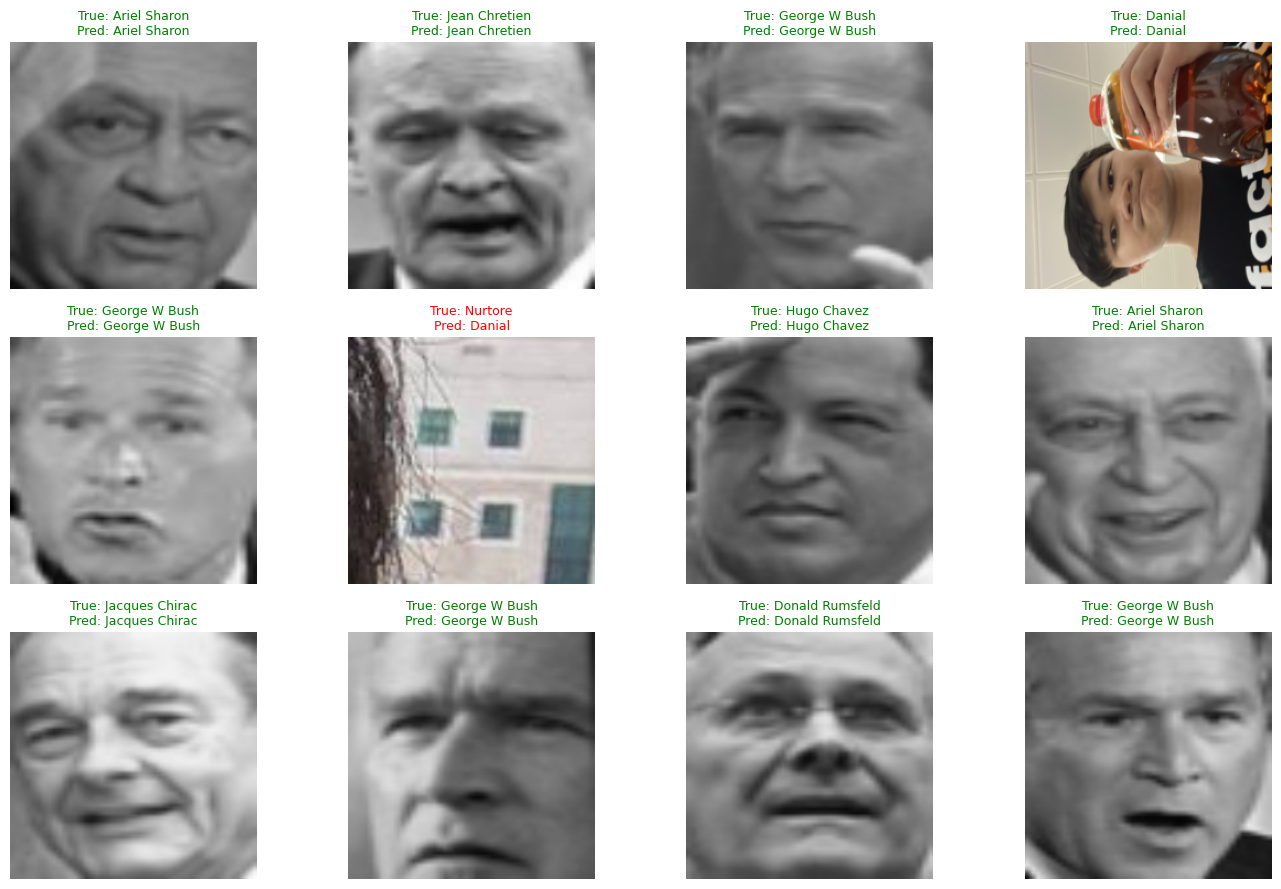

In [20]:
visualize_predictions(test_loader, resnet, elm, target_names)


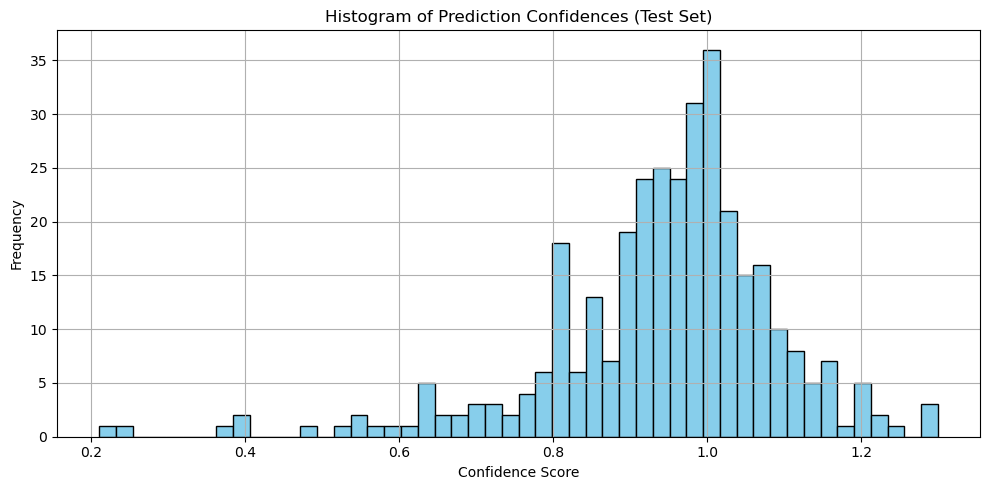

In [17]:
_, confidences = elm.predict_with_raw_output(X_test)

plt.figure(figsize=(10, 5))
plt.hist(confidences, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Prediction Confidences (Test Set)")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
def visualize_wrong_predictions(X_test_feats, y_test, y_pred, dataset, target_names, elm, num_wrong=10):
    import matplotlib.pyplot as plt
    wrong_indices = [i for i in range(len(y_test)) if y_test[i] != y_pred[i]]
    sample_wrong = random.sample(wrong_indices, min(num_wrong, len(wrong_indices)))

    fig, axes = plt.subplots(2, 5, figsize=(14, 6))
    axes = axes.flatten()

    for i, idx in enumerate(sample_wrong):
        img, _ = dataset[idx]
        img_disp = img.permute(1, 2, 0).numpy()
        img_disp = (img_disp * 0.5 + 0.5).clip(0, 1)

        axes[i].imshow(img_disp)
        axes[i].set_title(f"True: {target_names[y_test[idx]]}\nPred: {target_names[y_pred[idx]]}", color='red', fontsize=9)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


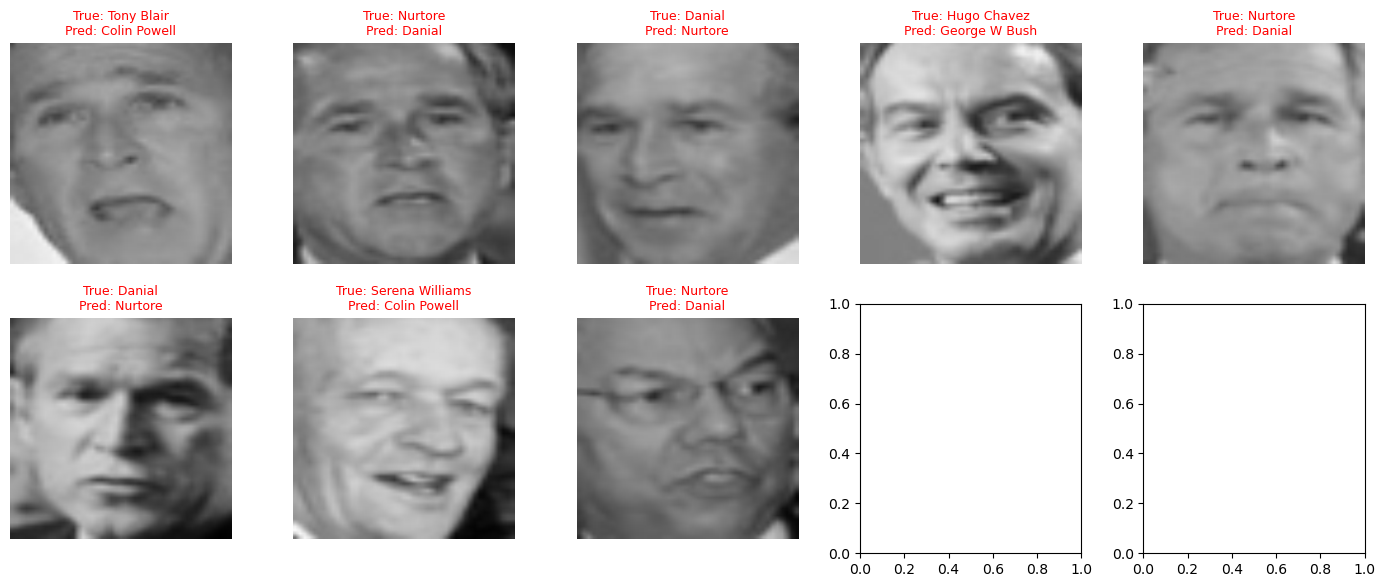

In [25]:
visualize_wrong_predictions(X_test, y_test, y_pred, dataset, target_names, elm)

# Live predictiong

In [13]:
device = "cpu"

In [14]:
cap = cv2.VideoCapture(0)
mtcnn_video = MTCNN(keep_all=True, device=device)  # detects multiple faces
while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)
    # Convert to RGB (MTCNN expects RGB)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(rgb_frame)


    
    # Detect faces using MTCNN
    boxes, _ = mtcnn_video.detect(img_pil)

    if boxes is not None:
        for box in boxes:
            x1, y1, x2, y2 = [int(coord) for coord in box]

            # Crop and preprocess face
            face_crop = img_pil.crop((x1, y1, x2, y2))
            face_tensor = transform(face_crop).unsqueeze(0).to(device)

            # Feature extraction
            with torch.no_grad():
                features = resnet(face_tensor).cpu().numpy()

            # Predict with ELM and get confidence
            pred_idx, confidence = elm.predict_with_raw_output(features)
            label = target_names[pred_idx[0]]
            score = confidence[0]

            # Draw results
            # Draw results
            # if score < 0.5:
            #     display_label = "Unverified"
            #     color = (0, 0, 255)  # Red
            # else:
            display_label = f"{label} ({score:.2f})"
            color = (0, 255, 0)  # Green
            
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, display_label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
            # Feature extraction
            # with torch.no_grad():
            #     features = resnet(face_tensor).cpu().numpy()

            # # Predict with ELM
            # pred_idx = elm.predict(features)[0]
            # label = target_names[pred_idx]

            # # Draw results
            # cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

    cv2.imshow('Live Face Recognition', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


2025-04-26 23:29:51.634 python[87688:778939] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
2025-04-26 23:29:54.597 python[87688:778939] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-26 23:29:54.597 python[87688:778939] +[IMKInputSession subclass]: chose IMKInputSession_Modern
